# Introduction

The tutorial demonstrates how to train a BERT-Mini model on SST-2 dataset through distillation, and how to leverage quantization to accelerate the inference while maintaining the accuracy using Intel® Neural Compressor. Our BERT-Mini model (distilled + quantized) shows **16.47x** performance speedup over BERT-Base (PyTorch) and **8.77x** speedup over BERT-Base (ONNX Runtime) while keeping similar accuracy, and improves the accuracy by **6.9%** on SST-2 dataset over default BERT-Mini. Please note that the performance is measured on AWS cloud instance type [c6i.16xlarge](https://aws.amazon.com/ec2/instance-types/), so the performance varies by use, configuration and other factors.

# Prerequisite

## Installing packages

In [1]:
!pip install datasets matplotlib neural_compressor onnxruntime onnxruntime_extensions pandas scipy torch==1.10.0 transformers[tf,torch,sentencepiece,vision,sklearn,onnxruntime]==4.11.3

## Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from psutil import cpu_count
import torch
import torch.nn.functional as F
from datasets import (
    Dataset, 
    load_dataset, 
    load_metric
)
from neural_compressor.experimental import Quantization, common
from onnxruntime import (
    GraphOptimizationLevel, 
    InferenceSession, 
    SessionOptions
)
from pathlib import Path
from scipy.special import softmax
from time import perf_counter
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding, 
    pipeline, 
    TrainingArguments, 
    Trainer
)
from transformers.convert_graph_to_onnx import convert

/home/ubuntu/anaconda3/envs/py3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-05-20 05:27:11.453552: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-20 05:27:11.456993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 05:27:11.457003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Distillation

## Load datasets

In [3]:
sst_dataset = load_dataset('glue', 'sst2')
augmented_sst2_dataset = load_dataset("jmamou/augmented-glue-sst2")    # Augmented data base on GPT-2 generation 

# Load the test dataset into a pandas dataframe.
test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

text_col=test_df.columns.values[0]
category_col=test_df.columns.values[1]

x_test = test_df[text_col].values.tolist()
y_test = test_df[category_col].values.tolist()
value2hot = {
  0: [1,0],
  1: [0,1]
}

#Set training data: aug + psedu labels 
raw_train_ds = augmented_sst2_dataset['train']
raw_train_ds = raw_train_ds.rename_column('prediction','score')
raw_train_ds = raw_train_ds.remove_columns('label')

# Set Validation and test data 
val_dict = {"sentence":sst_dataset['validation']['sentence'],"score":[value2hot[l] for l in sst_dataset['validation']['label']]}
raw_val_ds = Dataset.from_dict(val_dict)

test_dict = {"sentence":x_test,"score":[value2hot[l] for l in y_test]}
raw_test_ds = Dataset.from_dict(test_dict)

# create label2id, id2label dicts for nice outputs for the model
labels = sst_dataset['train'].features["label"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

2022-05-20 05:27:15 [WARNING] Reusing dataset glue (/home/ubuntu/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1216.45it/s]
2022-05-20 05:27:15 [WARNING] Using custom data configuration default
2022-05-20 05:27:15 [WARNING] Reusing dataset augmented_glue_sst2 (/home/ubuntu/.cache/huggingface/datasets/jmamou___augmented_glue_sst2/default/0.0.0/247b2b4c3f1b4f6143d2de4b57cb43c1464ff5a3b0b46eeac207ca6795138475)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 640.06it/s]


## Tokenize datasets for training

In [4]:
student_id = "google/bert_uncased_L-4_H-256_A-4"

tokenizer = AutoTokenizer.from_pretrained(student_id)
ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=64)
    
    # Change this to real number
    examples["label"] = [float(i) for i in label]

    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["sentence","score"])

2022-05-20 05:27:20 [WARNING] Parameter 'function'=<function preprocess_function at 0x7f2f58043560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 5697.18ex/s]


## Prepare training configuration

In [5]:
LEARNING_RATE = 6e-5
MAX_LENGTH = 64
BATCH_SIZE = 128
EPOCHS = 7
model_output_dir = "bert-mini-sst2-distilled"

training_args = TrainingArguments(
    output_dir=model_output_dir,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    overwrite_output_dir=True
)

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = load_metric("accuracy")

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    hot_labels = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=hot_labels)


## Prepare model

In [6]:
# define student model
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_id,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

## Training by distillation

In [7]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)  
        logits = outputs.logits
        loss = F.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = RegressionTrainer(
    student_model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()
trainer.save_model(model_output_dir)

***** Running training *****
  Num examples = 797056
  Num Epochs = 7
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 43589


Epoch,Training Loss,Validation Loss,Accuracy
1,0.067200,0.070249,0.907110
2,0.055600,0.071456,0.910550
3,0.048000,0.067444,0.916284
4,0.042400,0.069069,0.910550
5,0.038600,0.067889,0.910550
6,0.035900,0.068086,0.907110
7,0.033200,0.069872,0.905963


***** Running Evaluation *****
  Num examples = 872
  Batch size = 128
Saving model checkpoint to bert-mini-sst2-distilled/checkpoint-6227
Configuration saved in bert-mini-sst2-distilled/checkpoint-6227/config.json
Model weights saved in bert-mini-sst2-distilled/checkpoint-6227/pytorch_model.bin
tokenizer config file saved in bert-mini-sst2-distilled/checkpoint-6227/tokenizer_config.json
Special tokens file saved in bert-mini-sst2-distilled/checkpoint-6227/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 872
  Batch size = 128
Saving model checkpoint to bert-mini-sst2-distilled/checkpoint-12454
Configuration saved in bert-mini-sst2-distilled/checkpoint-12454/config.json
Model weights saved in bert-mini-sst2-distilled/checkpoint-12454/pytorch_model.bin
tokenizer config file saved in bert-mini-sst2-distilled/checkpoint-12454/tokenizer_config.json
Special tokens file saved in bert-mini-sst2-distilled/checkpoint-12454/special_tokens_map.json
***** Running Evaluation 

## Evaluate the trained model

In [8]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1821
  Batch size = 128


{'eval_loss': 0.05587170273065567,
 'eval_accuracy': 0.9275123558484349,
 'eval_runtime': 0.6307,
 'eval_samples_per_second': 2887.439,
 'eval_steps_per_second': 23.785,
 'epoch': 7.0}

# Results

- With distillation, we managed to achieve the comparable accuracy of BERT-Mini (92.8%) compared to BERT-Base (94.0%) on SST-2 dataset than BERT-Mini without distillation (85.9%).
<br>
- In this section, we will illustrate how to improve the performance of the BERT-Mini while maintain this comparable accuracy. 
<br>
- By leveraging quantization and Reference NLP Engine, BERT-Mini (Reference NLP Engine INT8) achieves 16.47X speedup compared to BERT-Base (PyTorch FP32) (1.04ms vs. 17.13ms) while kept the comparable accuracy (92.8% vs. 94%). Even compared with the quantized BERT-Base (ONNXRuntime INT8), BERT-Mini still outperform it with 8.77X speedup (1.04ms vs. 9.12ms) and maintain the comparable accuracy (92.8% vs. 93.5%).

## Creating a Performance Benchmark

In [9]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT-mini"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["sentence"])[0]['label']
            label = np.argmax(example["score"])
            preds.append(label2id[pred.lower()])
            labels.append(label)
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self):
        latencies = []
        # Warmup
        for idx in range(5):
            query = self.dataset[idx % len(self.dataset)]['sentence']
            _ = self.pipeline(query)
        # Timed run
        for idx in range(100):
            query = self.dataset[idx % len(self.dataset)]['sentence']
            inputs = self.pipeline.tokenize(query)
            start_time = perf_counter()
            _ = self.pipeline.inference(inputs)
            latency = perf_counter() - start_time
            latencies.append(latency)
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

## Performance of PyTorch FP32 models

### Benchmarking of BERT-Mini PyTorch FP32 model

In [10]:
class PyTorchPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def tokenize(self, query):
        return self.tokenizer(query, truncation=True, padding="max_length", max_length=64, return_tensors="pt")

    def inference(self, inputs):
        return self.model(**inputs).logits

    def __call__(self, query):
        inputs = self.tokenize(query)
        logits = self.model(**inputs).logits[0].cpu().detach().numpy()
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": id2label[str(pred_idx)], "score": probs[pred_idx]}]
 
optim_type = "BERT-Mini (distilled) PyTorch FP32"
model = AutoModelForSequenceClassification.from_pretrained(
    model_output_dir,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)
pipe = PyTorchPipeline(model, tokenizer)
pb = PerformanceBenchmark(pipe, raw_test_ds, optim_type=optim_type)
perf_metrics = pb.run_benchmark()

loading configuration file bert-mini-sst2-distilled/config.json
Model config BertConfig {
  "_name_or_path": "google/bert_uncased_L-4_H-256_A-4",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "negative": "0",
    "positive": "1"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file bert-mini-sst2-distilled/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSe

Model size (MB) - 42.64
Average latency (ms) - 3.41 +\- 0.18
Accuracy on test set - 0.928


### Benchmarking of BERT-Mini PyTorch FP32 model without distillation

In [11]:
optim_type = "BERT-Mini PyTorch FP32"
model = AutoModelForSequenceClassification.from_pretrained(
    "M-FAC/bert-mini-finetuned-sst2",
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)
pipe = PyTorchPipeline(model, tokenizer)
pb = PerformanceBenchmark(pipe, raw_test_ds, optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

https://huggingface.co/M-FAC/bert-mini-finetuned-sst2/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/ubuntu/.cache/huggingface/transformers/tmphnninmxz
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 761/761 [00:00<00:00, 1.21MB/s]
storing https://huggingface.co/M-FAC/bert-mini-finetuned-sst2/resolve/main/config.json in cache at /home/ubuntu/.cache/huggingface/transformers/48093d9b019bf0a8fbf2af0ef388800f5d96f929f1d6cbbe0271c28169d56c52.336de9a86e2086b58871b65ea15bbe3fd8b8c9d3eec0456609987315c0b2a0c5
creating metadata file for /home/ubuntu/.cache/huggingface/transformers/48093d9b019bf0a8fbf2af0ef388800f5d96f929f1d6cbbe0271c28169d56c52.336de9a86e2086b58871b65ea15bbe3fd8b8c9d3eec0456609987315c0b2a0c5
loading configuration file https://huggingface.co/M-FAC/bert-mini-finetuned-sst2/resolve/main/config.json from cache at /home/

Model size (MB) - 42.64
Average latency (ms) - 3.43 +\- 0.31
Accuracy on test set - 0.859


### Benchmarking of BERT-Base PyTorch FP32 model

In [12]:
optim_type = "BERT-Base PyTorch FP32"
bertbase_path = "yoshitomo-matsubara/bert-base-uncased-sst2"
model = AutoModelForSequenceClassification.from_pretrained(
    bertbase_path,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)
pipe = PyTorchPipeline(model, tokenizer)
pb = PerformanceBenchmark(pipe, raw_test_ds, optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

loading configuration file https://huggingface.co/yoshitomo-matsubara/bert-base-uncased-sst2/resolve/main/config.json from cache at /home/ubuntu/.cache/huggingface/transformers/3fa06f198ea5e8b49c31ab2af91729743156d561fc91857a860dbb6499135c92.e93428b26b03e1f5a1b5f0a2dfb9379950f0681e923b99c502af6f00b5b4390a
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "sst2",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": "0",
    "positive": "1"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_

Model size (MB) - 417.73
Average latency (ms) - 17.13 +\- 0.99
Accuracy on test set - 0.940


## Deployment on ONNX Runtime

### Convert PyTorch FP32 model to ONNXRuntime FP32 model

In [13]:
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
onnx_bertmini_model_path = Path("onnx_bert_mini/model.onnx")
onnx_bertbase_model_path = Path("onnx_bert_base/model.onnx")
convert(framework="pt", model=model_output_dir, tokenizer=tokenizer, 
        output=onnx_bertmini_model_path, opset=12, pipeline_name="text-classification")
convert(framework="pt", model=bertbase_path, tokenizer=tokenizer, 
        output=onnx_bertbase_model_path, opset=12, pipeline_name="text-classification")

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = cpu_count()
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_bertmini_model = create_model_for_provider(onnx_bertmini_model_path)
onnx_bertbase_model = create_model_for_provider(onnx_bertbase_model_path)

loading configuration file bert-mini-sst2-distilled/config.json
Model config BertConfig {
  "_name_or_path": "google/bert_uncased_L-4_H-256_A-4",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "negative": "0",
    "positive": "1"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file bert-mini-sst2-distilled/config.json
Model config BertConfig {
  "_name_or_path": "google/bert_uncased_

ONNX opset version set to: 12
Loading pipeline (model: bert-mini-sst2-distilled, tokenizer: PreTrainedTokenizerFast(name_or_path='google/bert_uncased_L-4_H-256_A-4', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder onnx_bert_mini
Using framework PyTorch: 1.10.0+cu102
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


loading configuration file https://huggingface.co/yoshitomo-matsubara/bert-base-uncased-sst2/resolve/main/config.json from cache at /home/ubuntu/.cache/huggingface/transformers/3fa06f198ea5e8b49c31ab2af91729743156d561fc91857a860dbb6499135c92.e93428b26b03e1f5a1b5f0a2dfb9379950f0681e923b99c502af6f00b5b4390a
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "sst2",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.11.3",
  "type_vo

ONNX opset version set to: 12
Loading pipeline (model: yoshitomo-matsubara/bert-base-uncased-sst2, tokenizer: PreTrainedTokenizerFast(name_or_path='google/bert_uncased_L-4_H-256_A-4', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))


loading weights file https://huggingface.co/yoshitomo-matsubara/bert-base-uncased-sst2/resolve/main/pytorch_model.bin from cache at /home/ubuntu/.cache/huggingface/transformers/56a5b237d1d62a5cf2d22552526940e6b0b4a9bc92370a44214f23b63547907a.f86bbbd8c7c415ce6e248175a0e2b9adba78621c10933487da3243eed7673c95
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at yoshitomo-matsubara/bert-base-uncased-sst2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


Creating folder onnx_bert_base
Using framework PyTorch: 1.10.0+cu102
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


### Benchmarking of BERT-Mini ONNXRuntime FP32 model

In [14]:
class OnnxPipeline(PyTorchPipeline):
    def __init__(self, model, tokenizer):
        super(OnnxPipeline, self).__init__(model, tokenizer)

    def inference(self, inputs):
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in inputs.items()}
        return self.model.run(None, inputs_onnx)[0][0, :]

    def __call__(self, query):
        model_inputs = self.tokenize(query)
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": id2label[str(pred_idx)], "score": probs[pred_idx]}]

pipe = OnnxPipeline(onnx_bertmini_model, tokenizer)

class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

optim_type = "BERT-Mini (distilled) ONNX Runtime FP32"
pb = OnnxPerformanceBenchmark(pipe, raw_test_ds, optim_type,
                              model_path="onnx_bert_mini/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 42.64
Average latency (ms) - 1.46 +\- 0.03
Accuracy on test set - 0.928


### Quantize BERT-Mini ONNXRuntime FP32 model via INC

In [15]:
class DatasetForINC():
    def __init__(self, dataset, engine_order=False):
        self.dataset = dataset
        self.engine_order = engine_order

    def __getitem__(self, idx):
        input_ids_data = self.dataset[idx]['input_ids']
        segment_ids_data = self.dataset[idx]['token_type_ids']
        input_mask_data = self.dataset[idx]['attention_mask']
        label_data = self.dataset[idx]['label']
        if self.engine_order:
            return (np.array(input_ids_data).astype('int32'),
                    np.array(segment_ids_data).astype('int32'),
                    np.array(input_mask_data).astype('int32')), np.argmax(label_data, axis=-1)
        return (np.array(input_ids_data).astype('int64'),
                np.array(input_mask_data).astype('int64'),
                np.array(segment_ids_data).astype('int64')), np.argmax(label_data, axis=-1)

    def __len__(self):
        return len(self.dataset)

model_input = "onnx_bert_mini/model.onnx"
model_output = "onnx_bert_mini/model.quant.onnx"
quantizer = Quantization("bert-mini_static.yaml")
quantizer.model = common.Model(model_input)
quantizer.eval_dataloader = common.DataLoader(DatasetForINC(ds["validation"]), 1)
quantizer.calib_dataloader = common.DataLoader(DatasetForINC(ds["validation"]), 1)
q_model = quantizer()
q_model.save(model_output)

2022-05-23 02:21:28 [INFO] Get FP32 model baseline.
/home/ubuntu/anaconda3/envs/py3.7/lib/python3.7/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/ubuntu/anaconda3/envs/py3.7/lib/python3.7/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
2022-05-23 02:21:29 [INFO] Save tuning history to /home/ubuntu/bert_mi

### Quantize BERT-Base ONNXRuntime FP32 model

In [16]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx_bert_base/model.onnx"
model_output = "onnx_bert_base/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"239" not specified
2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"312" not specified
2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"327" not specified


Ignore MatMul due to non constant B: /[MatMul_70]
Ignore MatMul due to non constant B: /[MatMul_75]


2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"338" not specified
2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"353" not specified
2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"426" not specified
2022-05-23 02:17:23 [INFO] Quantization parameters for tensor:"441" not specified


Ignore MatMul due to non constant B: /[MatMul_164]
Ignore MatMul due to non constant B: /[MatMul_169]


2022-05-23 02:17:24 [INFO] Quantization parameters for tensor:"452" not specified
2022-05-23 02:17:24 [INFO] Quantization parameters for tensor:"467" not specified
2022-05-23 02:17:24 [INFO] Quantization parameters for tensor:"540" not specified
2022-05-23 02:17:24 [INFO] Quantization parameters for tensor:"555" not specified


Ignore MatMul due to non constant B: /[MatMul_258]
Ignore MatMul due to non constant B: /[MatMul_263]


2022-05-23 02:17:24 [INFO] Quantization parameters for tensor:"566" not specified
2022-05-23 02:17:24 [INFO] Quantization parameters for tensor:"581" not specified
2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"654" not specified
2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"669" not specified


Ignore MatMul due to non constant B: /[MatMul_352]
Ignore MatMul due to non constant B: /[MatMul_357]


2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"680" not specified
2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"695" not specified
2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"768" not specified
2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"783" not specified


Ignore MatMul due to non constant B: /[MatMul_446]
Ignore MatMul due to non constant B: /[MatMul_451]


2022-05-23 02:17:25 [INFO] Quantization parameters for tensor:"794" not specified
2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"809" not specified
2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"882" not specified
2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"897" not specified


Ignore MatMul due to non constant B: /[MatMul_540]
Ignore MatMul due to non constant B: /[MatMul_545]


2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"908" not specified
2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"923" not specified
2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"996" not specified
2022-05-23 02:17:26 [INFO] Quantization parameters for tensor:"1011" not specified


Ignore MatMul due to non constant B: /[MatMul_634]
Ignore MatMul due to non constant B: /[MatMul_639]


2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1022" not specified
2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1037" not specified
2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1110" not specified
2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1125" not specified


Ignore MatMul due to non constant B: /[MatMul_728]
Ignore MatMul due to non constant B: /[MatMul_733]


2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1136" not specified
2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1151" not specified
2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1224" not specified
2022-05-23 02:17:27 [INFO] Quantization parameters for tensor:"1239" not specified


Ignore MatMul due to non constant B: /[MatMul_822]
Ignore MatMul due to non constant B: /[MatMul_827]


2022-05-23 02:17:28 [INFO] Quantization parameters for tensor:"1250" not specified
2022-05-23 02:17:28 [INFO] Quantization parameters for tensor:"1265" not specified
2022-05-23 02:17:28 [INFO] Quantization parameters for tensor:"1338" not specified
2022-05-23 02:17:28 [INFO] Quantization parameters for tensor:"1353" not specified


Ignore MatMul due to non constant B: /[MatMul_916]
Ignore MatMul due to non constant B: /[MatMul_921]


2022-05-23 02:17:28 [INFO] Quantization parameters for tensor:"1364" not specified
2022-05-23 02:17:28 [INFO] Quantization parameters for tensor:"1379" not specified
2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1452" not specified
2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1467" not specified


Ignore MatMul due to non constant B: /[MatMul_1010]
Ignore MatMul due to non constant B: /[MatMul_1015]


2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1478" not specified
2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1493" not specified
2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1566" not specified
2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1581" not specified


Ignore MatMul due to non constant B: /[MatMul_1104]
Ignore MatMul due to non constant B: /[MatMul_1109]


2022-05-23 02:17:29 [INFO] Quantization parameters for tensor:"1592" not specified
2022-05-23 02:17:30 [INFO] Quantization parameters for tensor:"1609" not specified
2022-05-23 02:17:30 [INFO] Quantization parameters for tensor:"1611" not specified


### Benchmarking of BERT-Mini ONNXRuntime INT8 model

In [17]:
model_output = "onnx_bert_mini/model.quant.onnx"
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "BERT-Mini (distilled) ONNX Runtime INT8"
pb = OnnxPerformanceBenchmark(pipe, raw_test_ds, optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 10.91
Average latency (ms) - 1.64 +\- 0.03
Accuracy on test set - 0.926


### Benchmarking of BERT-Base ONNXRuntime INT8 model

In [18]:
model_output = "onnx_bert_base/model.quant.onnx"
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "BERT-Base ONNX Runtime INT8"
pb = OnnxPerformanceBenchmark(pipe, raw_test_ds, optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 104.86
Average latency (ms) - 9.12 +\- 0.13
Accuracy on test set - 0.935


## Deployment on Reference NLP Engine

In [19]:
os.environ["GLOG_minloglevel"] = "2"
model_input = "onnx_bert_mini/model.onnx"
model_output = "bert-mini_engine_int8"
quantizer = Quantization("bert-mini_engine_static.yaml")
quantizer.model = common.Model(model_input)
quantizer.eval_dataloader = common.DataLoader(DatasetForINC(ds["validation"], engine_order=True), 1)
quantizer.calib_dataloader = common.DataLoader(DatasetForINC(ds["validation"], engine_order=True), 1)
q_model = quantizer()
q_model.save(model_output)

2022-05-20 07:24:32 [INFO] Start to extarct onnx model ops...
2022-05-20 07:24:32 [INFO] Extract onnxruntime model done...
2022-05-20 07:24:32 [INFO] Start to implement Sub-Graph matching and replacing...
2022-05-20 07:24:32 [WARNING] Does not completely support this pattern: [[(0, 'Shape'), (1, 'Gather'), (2, 'Unsqueeze'), (6, 'Concat'), (7, 'Reshape'), (8, 'MatMulWithBias')], [(), (3, 'Shape'), (4, 'Gather'), (5, 'Unsqueeze'), (6, 'Concat')]] now, please check the output results.
2022-05-20 07:24:32 [WARNING] Does not completely support this pattern: [[(0, 'MatMulWithBias'), (1, 'Shape'), (2, 'Gather'), (3, 'Unsqueeze'), (7, 'Concat'), (8, 'Reshape')], [(), (4, 'Shape'), (5, 'Gather'), (6, 'Unsqueeze'), (7, 'Concat')]] now, please check the output results.
2022-05-20 07:24:32 [WARNING] Does not completely support this pattern: [[(0, 'Transpose'), (2, 'MatMul'), (3, 'Div'), (4, ['AddV2', 'Add'])], [(), (1, 'Transpose'), (2, 'MatMul')]] now, please check the output results.
2022-05-20 

### Benchmarking of BERT-Mini Reference NLP Engine INT8 model

In [20]:
class EnginePipeline(PyTorchPipeline):
    def __init__(self, model, tokenizer):
        super(EnginePipeline, self).__init__(model, tokenizer)

    def tokenize(self, query):
        return self.tokenizer(query, truncation=True, padding="max_length", max_length=64, return_tensors="pt")

    def inference(self, inputs):
        inputs = {k: v.cpu().detach().numpy().astype(np.int32)
                      for k, v in inputs.items()}
        keys = ['input_ids', 'token_type_ids', 'attention_mask']
        return list(self.model.inference([inputs[k] for k in keys]).values())[0]

    def __call__(self, query):
        model_inputs = self.tokenize(query)
        inputs = {k: v.cpu().detach().numpy().astype(np.int32)
                      for k, v in model_inputs.items()}
        keys = ['input_ids', 'token_type_ids', 'attention_mask']
        logits = list(self.model.inference([inputs[k] for k in keys]).values())[0]
        probs = softmax(logits)[0]
        pred_idx = np.argmax(probs).item()
        return [{"label": id2label[str(pred_idx)], "score": probs[pred_idx]}]

class EnginePerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = \
            Path(os.path.join(self.model_path, 'model.bin')).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

model_output = "bert-mini_engine_int8"
q_model = common.Model(model_output)
pipe = EnginePipeline(q_model, tokenizer)
optim_type = "BERT-Mini (distilled) Ref Engine INT8"
pb = EnginePerformanceBenchmark(pipe, raw_test_ds, optim_type, 
                                model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 33.50
Average latency (ms) - 1.04 +\- 0.02
Accuracy on test set - 0.928


## Plot accuracy vs. latency

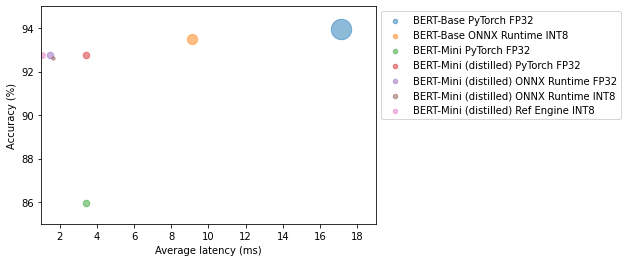

In [21]:
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(85,95)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT-Base PyTorch FP32"]["time_avg_ms"] + 2)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

optim_types = ['BERT-Base PyTorch FP32',
               'BERT-Base ONNX Runtime INT8',
               'BERT-Mini PyTorch FP32',
               'BERT-Mini (distilled) PyTorch FP32',
               'BERT-Mini (distilled) ONNX Runtime FP32',
               'BERT-Mini (distilled) ONNX Runtime INT8',
               'BERT-Mini (distilled) Ref Engine INT8']
plot_metrics({k:perf_metrics[k] for k in optim_types}, optim_type)